### Область работы 1 (библиотеки)

In [1155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve

import sklearn
print(sklearn.__version__)

1.3.0


### Область работы 2 (поиск  модели)

In [2380]:
path_train = 'train.csv'

####  Загрузка и обработка тренировочных данных

По условию задачи требуется научиться хорошо различать качественное вино. Исходные значения качества вина назовем группами качества и перенесем в столбец "groups". Определим вина групп качества 7, 8, 9 как целевой класс и обозначим его 1, остальные вина обозначим как класс 0. Значения классов присвоим столбцу "quality".

In [2381]:
data = pd.read_csv(path_train)

data['group'] = data['quality']
data['quality'] = (data['quality'] >= 7)*1

data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,group
0,6.4,0.17,0.34,1.5,0.091,42.0,135.0,0.9938,3.25,0.49,9.6,1,7
1,8.0,0.42,0.36,5.0,0.037,34.0,101.0,0.9920,3.13,0.57,12.3,1,7
2,6.7,0.27,0.25,8.0,0.053,54.0,202.0,0.9961,3.22,0.43,9.3,0,5


In [2246]:
print("группы качества вина:", f"{np.sort(data['group'].unique())}".replace("[", "").replace("]", "").replace(" ", ", "))

группы качества вина: 3, 4, 5, 6, 7, 8, 9


#### Первичный анализ

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1725 non-null   float64
 1   volatile acidity      1725 non-null   float64
 2   citric acid           1725 non-null   float64
 3   residual sugar        1725 non-null   float64
 4   chlorides             1725 non-null   float64
 5   free sulfur dioxide   1725 non-null   float64
 6   total sulfur dioxide  1725 non-null   float64
 7   density               1725 non-null   float64
 8   pH                    1725 non-null   float64
 9   sulphates             1725 non-null   float64
 10  alcohol               1725 non-null   float64
 11  quality               1725 non-null   int32  
dtypes: float64(11), int32(1)
memory usage: 155.1 KB


In [62]:
data.duplicated().sum()

0

In [11]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000,1725.000000
mean,6.821797,0.283849,0.332545,5.725652,0.044460,34.615072,135.248116,0.993532,3.201449,0.492394,10.734348,0.358261
std,0.853886,0.106090,0.122279,4.570812,0.021236,16.751535,42.848854,0.002830,0.151395,0.121452,1.272796,0.479628
min,3.900000,0.085000,0.000000,0.600000,0.012000,3.000000,10.000000,0.987110,2.830000,0.220000,8.400000,0.000000
25%,6.300000,0.210000,0.270000,1.600000,0.034000,23.000000,105.000000,0.991320,3.100000,0.400000,9.600000,0.000000
50%,6.800000,0.270000,0.320000,4.600000,0.041000,33.000000,130.000000,0.993200,3.190000,0.480000,10.600000,0.000000
75%,7.300000,0.330000,0.380000,8.700000,0.049000,45.000000,164.000000,0.995500,3.300000,0.560000,11.700000,1.000000
max,11.800000,1.100000,1.660000,20.700000,0.290000,124.000000,366.500000,1.001820,3.820000,1.080000,14.200000,1.000000


In [2248]:
#функция для гистограмм

def histogram(df, 
              ncols = 3,              #количество столбцов сетки
              bins = 50,              #количество интервалов гистограммы
              bcolor = '.9',          #цвет фона графика
              hcolor = 'Chocolate',   #цвет графика
              title = False):         #нужно ли заглавие
    
    n = len(df.columns)               #количество графиков
    a = round(n/ncols + 0.49)         #количество строк сетки графиков, округление в большую сторону
    
    sns.set_style('darkgrid', {'axes.facecolor': bcolor})
    sns.set_context('paper')
    
    fg = plt.figure(figsize = (9, 9*a/(ncols+1)), layout = 'constrained')  #числа выведены эмпирически
    gs = fg.add_gridspec(ncols = ncols, nrows = a)
    
    if (title == True): fg.suptitle("count of values", x = 0.5, y = 1 + 0.167*ncols/n, fontsize = 12, fontweight = 'bold')
       
    for i in range(n):
        
        column = df.iloc[:,i]
        
        if ('float' in str(column.dtype) or 'int' in str(column.dtype)):
            
            if ('int' in str(column.dtype)): discrete = True
            else: discrete = False
            
            #строка i-го графика - округление в большую сторону, столбец i-го графика - остаток целочисленного деления
            fg.add_subplot(gs[round((i + 1)/ncols + 0.49) - 1, i%ncols], title = column.name, xlabel = ' ', ylabel = ' ')
            sns.histplot(column, bins = bins, discrete = discrete, color = hcolor, edgecolor = hcolor)
            
        else: print("\033[31m{}".format(f"ошибка: столбец {column.name} содержит нечисловые данные"))

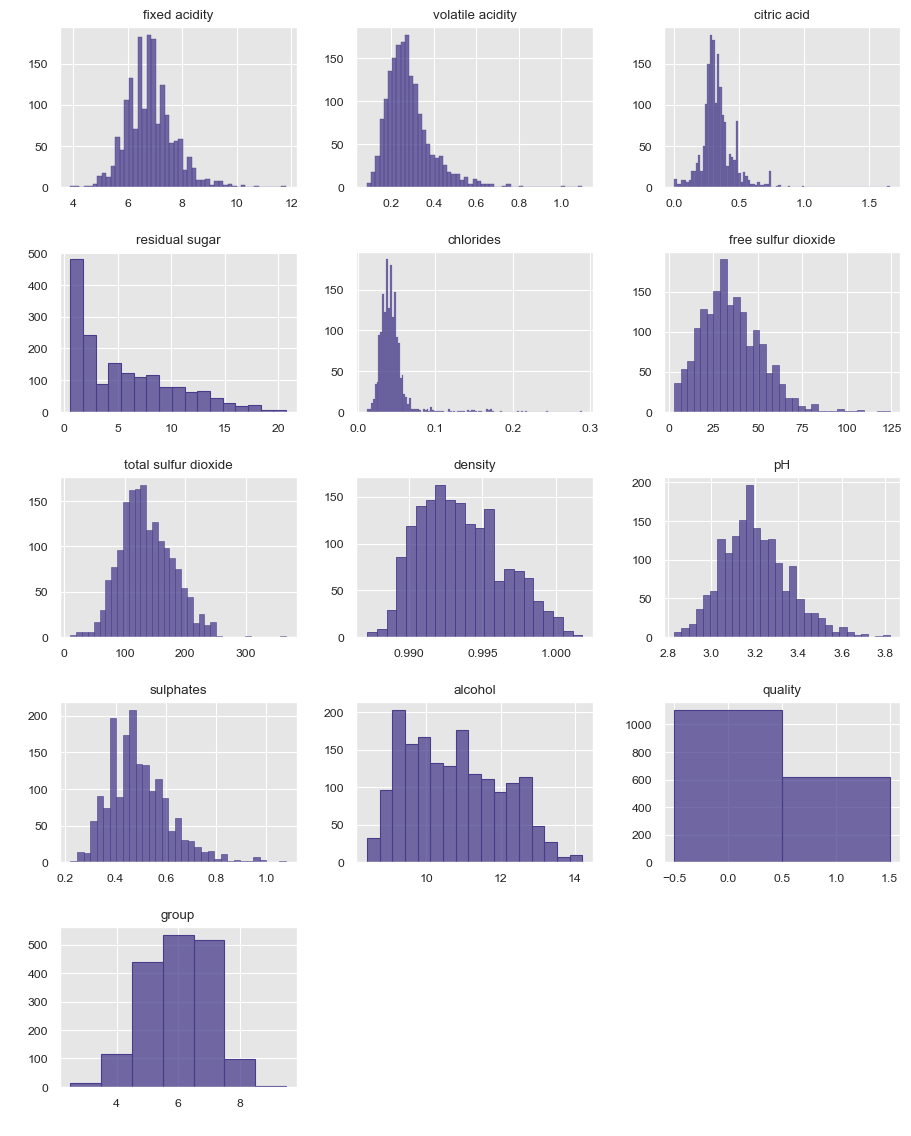

In [2249]:
histogram(data, 3, 'auto', hcolor = "darkslateblue")

In [2234]:
features = data.iloc[:,:-2]
features.corr()[(features.corr() > 0.4) & (features.corr() < 1)].dropna(thresh = 1).T.dropna(thresh = 1)

,residual sugar,free sulfur dioxide,total sulfur dioxide,density
residual sugar,NaN,NaN,0.438185,0.798569
free sulfur dioxide,NaN,NaN,0.605713,NaN
total sulfur dioxide,0.438185,0.605713,NaN,0.562273
density,0.798569,NaN,0.562273,NaN


- Пропущенные значения отсутствуют, тип данных корректен
- Дублированные строки отсутствуют
- Физических аномалий не наблюдается
- Классы имбалансны: доля целевого класса - 0.36, доля нулевого класса - 0.64
- Некоторые признаки сильно коррелированы с другими признаками

#### Деление на тренировочную и проверочную часть

Нужно проследить, чтобы элементы всех групп качества равномерно распределились между тренировочным и проверочным набором. Иначе может случиться так, что алгоритм обучался лишь на качественных винах групп 7 и 8, а при проверке встретил качественное вино группы 9 и неверно определил его как некачественное - это занизит score хорошей модели. Для этой цели в таблице был оставлен столбец "groups", по которому выполняется стратификация при делении данных на тренировочную и проверочную часть.

In [1632]:
X = data.iloc[:,:-2].values
y = data.iloc[:,[-2,-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    stratify = y[:,1])

groups_train = y_train[:,1]
groups_test = y_test[:,1]

y_train = y_train[:,0]
y_test = y_test[:,0]

In [205]:
print(f"X_train {X_train.shape}   y_train {y_train.shape}   X_test {X_test.shape}   y_test {y_test.shape}")

X_train (1380, 11)   y_train (1380,)   X_test (345, 11)   y_test (345,)


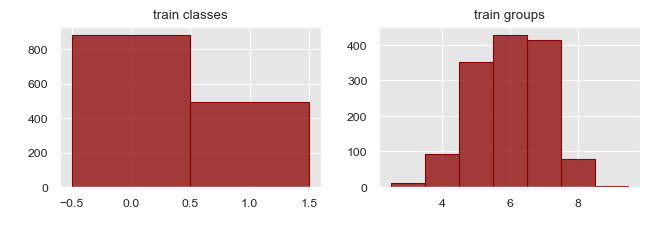

In [1633]:
histogram(pd.DataFrame({'train classes': y_train, 'train groups': groups_train}), hcolor = "darkred")

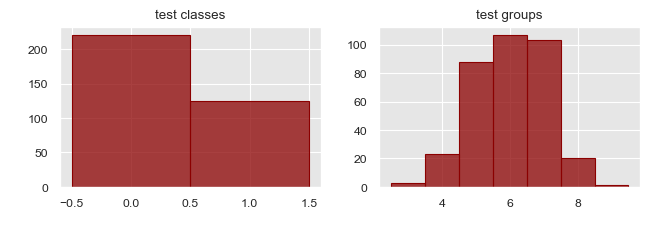

In [1634]:
histogram(pd.DataFrame({'test classes': y_test, 'test groups': groups_test}), hcolor = "darkred")

Задача - научиться приобретать качественное вино. То есть, если купленное вино оказалось некачественным, задача выполнена плохо. Таким образом, требуется минимизировать количество некачественных вин, ложно определенных как качественные. Это соответствует максимизации метрики precision, которая отражает долю действительно качественных вин среди всех вин, предсказанных как качественные. Итак, при поиске оптимальной модели в рамках данной задачи будет использована метрика precision. 

#### 1 Наивный байесовский классификатор

Итоговая метрика по результатам работы данного классификатора используется как базовое значение. Если результат других моделей машинного обучения хуже базового, их применение бессмысленно.

#### 1.1 Решетчатый поиск

In [2254]:
pipe_bayes = Pipeline([('preprocessing', StandardScaler()),
                       ('classifier', GaussianNB())])

param_bayes = [{'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()]} ]

cv = StratifiedShuffleSplit(n_splits = 7, test_size = 0.2)

grid_bayes = GridSearchCV(pipe_bayes, param_bayes, cv = cv, scoring = 'precision', return_train_score = True, n_jobs = -1)
grid_bayes.fit(X_train, y_train);

In [2255]:
drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']

rename = {'param_preprocessing': 'preprocessing'}

results_bayes = pd.DataFrame(grid_bayes.cv_results_).sort_values(['rank_test_score', 'std_test_score'])

display(results_bayes.drop(columns = drop).rename(columns = rename).T)

,0,1,2,3
preprocessing,StandardScaler(),MinMaxScaler(),RobustScaler(),Normalizer()
split0_test_score,0.587302,0.587302,0.587302,0.463855
split1_test_score,0.587413,0.587413,0.587413,0.534591
split2_test_score,0.542254,0.542254,0.542254,0.427835
split3_test_score,0.54,0.54,0.54,0.526316
split4_test_score,0.57554,0.57554,0.57554,0.509434
split5_test_score,0.578571,0.578571,0.578571,0.451282
split6_test_score,0.547945,0.547945,0.547945,0.458101
mean_test_score,0.565575,0.565575,0.565575,0.481631
std_test_score,0.019734,0.019734,0.019734,0.038283


#### 1.2 Итоговая модель

In [2256]:
pipe_bayes = make_pipeline(StandardScaler(), GaussianNB())
pipe_bayes.fit(X_train, y_train)

print(classification_report(y_test, pipe_bayes.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.856     0.697     0.768       221
           1      0.594     0.790     0.678       124

    accuracy                          0.730       345
   macro avg      0.725     0.744     0.723       345
weighted avg      0.762     0.730     0.736       345



#### 2 Логистическая регрессия

Данный алгоритм в зависимости от выбранного типа штрафования может как выкидывать лишние признаки, так и присваивать им меньший вес. Ранее было выяснено, что между некоторыми признаками присутствует сильная корреляция, которая, теоретически ухудшает показатели модели. Логично предположить, что в оптимуме тип штрафа будет не None.

#### 2.1 Решетчатый поиск

In [1642]:
pipe_logreg = Pipeline([('preprocessing', StandardScaler()), 
                        ('classifier', LogisticRegression(max_iter = 10000))])

param_logreg = [{'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
                 'classifier__penalty': [None],
                 'classifier__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
    
                {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
                 'classifier__penalty': ['l1'],
                 'classifier__solver': ['liblinear', 'saga']},
              
                {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
                 'classifier__penalty': ['l2'],
                 'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
               
                {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
                 'classifier__penalty': ['elasticnet'],
                 'classifier__solver': ['saga'],
                 'classifier__l1_ratio': np.arange(0, 1, 0.01)} ]

cv = StratifiedShuffleSplit(n_splits = 7, test_size = 0.2)

In [1645]:
start = time.time()

grid_logreg = GridSearchCV(pipe_logreg, param_logreg, cv = cv, scoring = 'precision', return_train_score = True, n_jobs = -1)
grid_logreg.fit(X_train, y_train)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 0.5 минут


In [1646]:
drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']

rename = {'param_classifier__penalty': 'penalty',
          'param_classifier__solver': 'solver',
          'param_classifier__l1_ratio': 'l1 ratio',
          'param_preprocessing': 'preprocessing'}

results_logreg = pd.DataFrame(grid_logreg.cv_results_).sort_values(['rank_test_score', 'std_test_score'])

display(results_logreg.drop(columns = drop).rename(columns = rename).T)

,19,15,117,101,105,109,113,81,33,89,...,107,139,111,143,147,119,123,127,131,135
penalty,None,None,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,l2,elasticnet,...,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet
solver,saga,sag,saga,saga,saga,saga,saga,saga,liblinear,saga,...,saga,saga,saga,saga,saga,saga,saga,saga,saga,saga
preprocessing,Normalizer(),Normalizer(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
l1 ratio,NaN,NaN,0.16,0.12,0.13,0.14,0.15,0.07,NaN,0.09,...,0.13,0.21,0.14,0.22,0.23,0.16,0.17,0.18,0.19,0.2
split0_test_score,0.756757,0.753425,0.722892,0.719512,0.719512,0.719512,0.719512,0.728395,0.719512,0.719512,...,0.6,0.545455,0.6,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455,0.545455
split1_test_score,0.657534,0.671233,0.678161,0.678161,0.678161,0.678161,0.678161,0.670455,0.674419,0.678161,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
split2_test_score,0.785714,0.771429,0.733333,0.733333,0.733333,0.733333,0.733333,0.72973,0.72973,0.72973,...,0.285714,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
split3_test_score,0.650602,0.646341,0.662791,0.662791,0.662791,0.662791,0.662791,0.662791,0.659091,0.662791,...,0.454545,0.5,0.454545,0.5,0.5,0.454545,0.454545,0.454545,0.454545,0.454545
split4_test_score,0.794118,0.797101,0.73494,0.73494,0.73494,0.73494,0.73494,0.73494,0.7375,0.73494,...,0.285714,0.285714,0.285714,0.25,0.25,0.285714,0.285714,0.285714,0.285714,0.285714
split5_test_score,0.716667,0.709677,0.725,0.725,0.725,0.725,0.725,0.725,0.721519,0.725,...,0.625,0.666667,0.625,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667


In [1872]:
mask_logreg = results_logreg.columns[results_logreg.columns.str.endswith("_test_score")][:-3]
table_logreg = results_logreg[mask_logreg][:6].T

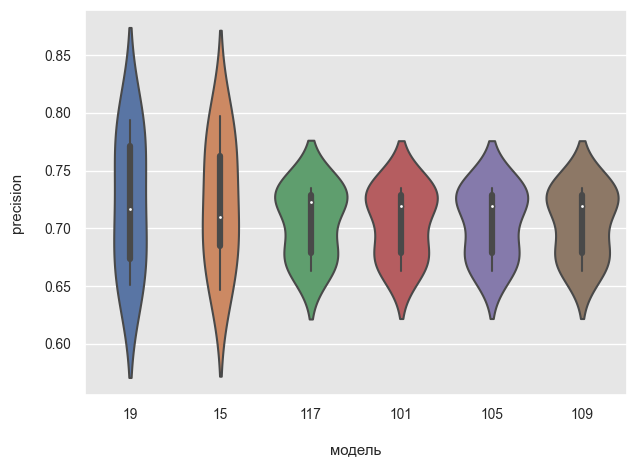

In [2260]:
sns.set_theme(font_scale = 0.9)
sns.set_style('darkgrid', {'axes.facecolor': '.9'})

plt.figure(figsize = (7, 5))
plt.xlabel("модель", labelpad = 15)
plt.ylabel("precision", labelpad = 15)

sns.violinplot(data = table_logreg);

По результатам решетчатого поиска:
- Первые две лучшие модели не штрафуют признаки.
- Модель 19 имеет самое высокое среднее значение precision по кроссвалидационным выборкам. При этом она обладает значительным разбросом - от 0.65 до 0.8, что говорит о нестабильности результата при использовании этой модели.
- Среди шести лучших моделей модель 117 имеет самое высокое медианное значение precision по кроссвалидационным выборкам. Ее разброс значений намного меньше, чем у модели 19, однако 75% квартиль расположен на 0.05 ниже.

Сравним модели 19 и 117, обучив их на всем тренировочном наборе.

In [2270]:
print(f"19: {results_logreg['params'][19]}".replace("{", "").replace("}", "").replace("'", ""))
print(f"117: {results_logreg['params'][117]}".replace("{", "").replace("}", "").replace("'", ""))

19: classifier__penalty: None, classifier__solver: saga, preprocessing: Normalizer()
117: classifier__l1_ratio: 0.16, classifier__penalty: elasticnet, classifier__solver: saga, preprocessing: MinMaxScaler()


In [2275]:
pipe_logreg1 = make_pipeline(Normalizer(),
                             LogisticRegression(penalty = None, solver = 'saga',
                                                max_iter = 10000))

pipe_logreg2 = make_pipeline(MinMaxScaler(),
                             LogisticRegression(penalty = 'elasticnet', l1_ratio = 0.16, solver = 'saga',
                                                max_iter = 10000))

pipe_logreg1.fit(X_train, y_train)
pipe_logreg2.fit(X_train, y_train)

print(f"модель 19\n{classification_report(y_test, pipe_logreg1.predict(X_test), digits = 3)}")
print(f"модель 117\n{classification_report(y_test, pipe_logreg2.predict(X_test), digits = 3)}")

модель 19
              precision    recall  f1-score   support

           0      0.771     0.900     0.831       221
           1      0.747     0.524     0.616       124

    accuracy                          0.765       345
   macro avg      0.759     0.712     0.724       345
weighted avg      0.763     0.765     0.754       345

модель 117
              precision    recall  f1-score   support

           0      0.778     0.855     0.815       221
           1      0.686     0.565     0.619       124

    accuracy                          0.751       345
   macro avg      0.732     0.710     0.717       345
weighted avg      0.745     0.751     0.745       345



У модели 117 precision на проверочном наборе ниже, чем у модели 19. Однако данная модель имеет возможность настройки параметра силы регуляризации, который отвечает за степень штрафования признаков. Попробуем оптимизировать модель 117 по этому параметру с помощью построения валидационной кривой.

#### 2.2 Валидационная кривая 

In [1680]:
n = np.linspace(0.0001, 6, 500) #сила регуляризации

pipe_logreg = make_pipeline(MinMaxScaler(),
                            LogisticRegression(penalty = 'elasticnet', l1_ratio = 0.16, solver = 'saga',
                                               max_iter = 10000))

cv = StratifiedShuffleSplit(n_splits = 7, test_size = 0.2)

train_scores, test_scores = validation_curve(pipe_logreg, X_train, y_train,
                                             param_name = 'logisticregression__C',
                                             param_range = n,
                                             cv = cv,
                                             scoring = 'precision',
                                             n_jobs = -1)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

максимум в точке 0.02415


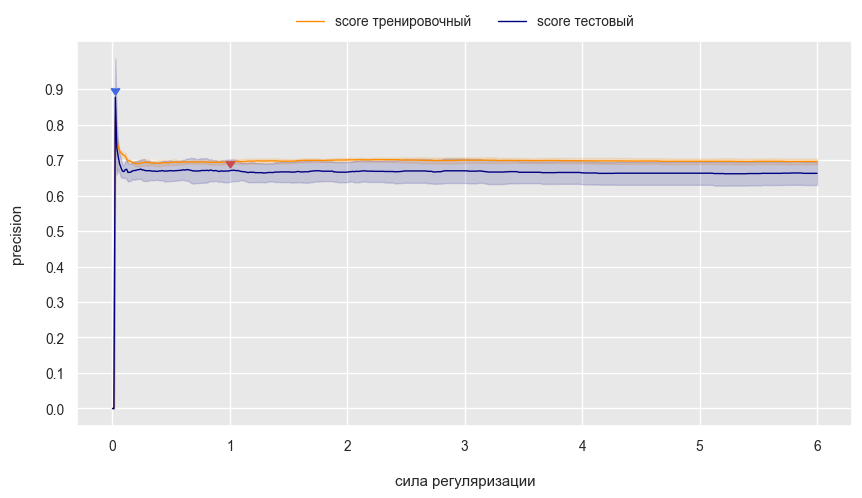

In [1722]:
sns.set_theme(font_scale = 0.9)
sns.set_style('darkgrid', {'axes.facecolor': '.91'})

plt.subplots(figsize = (10, 5), subplot_kw = dict(yticks = np.arange(0, 1, 0.1)))

sns.lineplot(y = train_mean, x = n, label = "score тренировочный", legend = False, color = 'darkorange', linewidth = 1)
plt.fill_between(n, train_mean - train_std, train_mean + train_std, color = 'darkorange', alpha = 0.15)

sns.lineplot(y = test_mean, x = n, label = "score тестовый", legend = False, color = 'navy', linewidth = 1)
plt.fill_between(n, test_mean - test_std, test_mean + test_std, color = 'navy', alpha = 0.15)

plt.scatter(n[test_mean.argmax()], test_mean.max() + 0.01, c = 'royalblue', marker = 7, zorder = 2)
plt.scatter(1, test_mean[np.abs(n-1).argmin()] + 0.01, c = 'r', marker = 7, zorder = 2)

plt.legend(ncol = 2, loc = 'upper center', bbox_to_anchor = (0, 0, 1, 1.1), framealpha = 0)

plt.xlabel("сила регуляризации", labelpad = 15)
plt.ylabel("precision", labelpad = 15);

print(f"максимум в точке {n[test_mean.argmax()]:.5f}")

In [2277]:
pipe_logreg = make_pipeline(MinMaxScaler(),
                            LogisticRegression(penalty = 'elasticnet', l1_ratio = 0.16, solver = 'saga', C = 0.02415,
                                               max_iter = 10000))

pipe_logreg.fit(X_train, y_train)

print(classification_report(y_test, pipe_logreg.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.674     0.982     0.799       221
           1      0.826     0.153     0.259       124

    accuracy                          0.684       345
   macro avg      0.750     0.568     0.529       345
weighted avg      0.729     0.684     0.605       345



Настройка силы регуляризации позволила улучшить проверочное значение precision модели 117 с 0.69 до 0.83 против 0.75 у модели 19. Также данная модель является более стабильной. Таким образом, модель 17 с параметром С = 0.02415 признана лучшей.

Посмотрим, какие коэффициенты были присвоены признакам, а также, какие признаки были исключены из рассмотрения.

In [2280]:
coefficients = pipe_logreg['logisticregression'].coef_[0]
dropped = data.iloc[:,:-2].columns.values[coefficients == 0]
weighted = data.iloc[:,:-2].columns.values[coefficients != 0]

weighted_index = np.where(pipe_logreg['logisticregression'].coef_[0] != 0)[0] #индексы оставшихся столбцов

print(f"взвешенные признаки:\n{pd.DataFrame(coefficients[coefficients != 0].round(3), weighted, ['coefficient'])}")
print(f"\n\nвыброшенные признаки:\n\n{dropped}".replace("[", "").replace("]", "").replace("' ", ",  ").replace("'", ""))

взвешенные признаки:
                      coefficient
volatile acidity           -0.029
residual sugar             -0.096
chlorides                  -0.083
total sulfur dioxide       -0.226
density                    -0.594
pH                          0.121
alcohol                     1.121


выброшенные признаки:

fixed acidity,  citric acid,  free sulfur dioxide,  sulphates


#### 2.3 Итоговая модель

Если модель 17 с штрафом L2 вместо elasticnet обучить на тренировочном наборе с уже выброшенными признаками, по идее должно получиться примерно то же самое, при этом модель станет проще. Как оказалось, такая модель также дает чуть более высокое значение проверочного precision и поэтому остается в качестве итоговой.

In [2162]:
pipe_logreg = make_pipeline(MinMaxScaler(),
                            LogisticRegression(penalty = 'l2', solver = 'saga', C = 0.02415,
                                               max_iter = 10000))

pipe_logreg.fit(X_train[:, weighted_index], y_train)

print(classification_report(y_test, pipe_logreg.predict(X_test[:, weighted_index]), digits = 3))

              precision    recall  f1-score   support

           0      0.678     0.982     0.802       221
           1      0.840     0.169     0.282       124

    accuracy                          0.690       345
   macro avg      0.759     0.576     0.542       345
weighted avg      0.736     0.690     0.615       345



#### 3 Метод ближайших соседей

#### 3.1 Решетчатый поиск

Чтобы ускорить перебор параметров классификатора по решетке, для начала значения дистанции и количества соседей берутся с шагом 5. Далее по результатам поиска определяется более ограниченный диапазон, в рамках которого эти параметры перебираются с шагом 1. 

При разбиении тренировочного набора на кроссвалидационные выборки фиксируется random_state. Если этого не сделать, с большой вероятностью случится так, что по GridSearchCV будут оптимальны модели из одного диапазона, а по температурной карте - совершенно из другого. Или на той же карте обнаружится краевое решение, хотя ограниченный диапазон взят с запасом.

In [2067]:
pipe_knn = Pipeline([('preprocessing', StandardScaler()), 
                     ('classifier', KNeighborsClassifier())])

param_knn = [{'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), Normalizer()],
              'classifier__n_neighbors': np.arange(1, 102, 5),
              'classifier__p': np.arange(1, 32, 5),
              'classifier__weights': ['uniform', 'distance'] }]

cv = StratifiedShuffleSplit(n_splits = 7, test_size = 0.2, random_state = 100)

In [2068]:
start = time.time()

grid_knn = GridSearchCV(pipe_knn, param_knn, cv = cv, scoring = 'precision', return_train_score = True, n_jobs = -1)
grid_knn.fit(X_train, y_train)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 11.3 минут


In [2069]:
drop = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']

rename = {'param_classifier__n_neighbors': 'n_neighbours',
          'param_classifier__p': 'p',
          'param_classifier__weights': 'weights',
          'param_preprocessing': 'preprocessing'}

results_knn = pd.DataFrame(grid_knn.cv_results_).sort_values(['rank_test_score', 'std_test_score'])

display(results_knn.drop(columns = drop).rename(columns = rename).T)

,948,940,960,932,916,700,872,924,104,888,...,19,23,27,31,51,55,35,39,43,47
n_neighbours,81,81,86,81,81,61,76,81,6,76,...,1,1,1,1,1,1,1,1,1,1
p,31,26,6,21,11,16,21,16,31,31,...,11,11,16,16,31,31,21,21,26,26
weights,distance,distance,uniform,distance,distance,distance,uniform,distance,uniform,uniform,...,uniform,distance,uniform,distance,uniform,distance,uniform,distance,uniform,distance
preprocessing,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer(),Normalizer()
split0_test_score,0.666667,0.670213,0.666667,0.670213,0.670213,0.652632,0.685393,0.670213,0.696203,0.689655,...,0.469565,0.469565,0.469565,0.469565,0.465517,0.465517,0.465517,0.465517,0.465517,0.465517
split1_test_score,0.776316,0.776316,0.777778,0.773333,0.753247,0.768293,0.75,0.763158,0.768116,0.753425,...,0.504505,0.504505,0.509091,0.509091,0.504587,0.504587,0.504587,0.504587,0.504587,0.504587
split2_test_score,0.709302,0.709302,0.707865,0.712644,0.711111,0.703297,0.698795,0.704545,0.686747,0.694118,...,0.53271,0.53271,0.537736,0.537736,0.53271,0.53271,0.537736,0.537736,0.53271,0.53271
split3_test_score,0.72619,0.72619,0.74026,0.725,0.722892,0.73494,0.728395,0.722892,0.666667,0.725,...,0.5,0.5,0.5,0.5,0.504673,0.504673,0.5,0.5,0.5,0.5
split4_test_score,0.715909,0.707865,0.688889,0.707865,0.7,0.689655,0.704545,0.7,0.666667,0.704545,...,0.537736,0.537736,0.527778,0.527778,0.513761,0.513761,0.513761,0.513761,0.513761,0.513761
split5_test_score,0.722222,0.722222,0.738636,0.719101,0.733333,0.725275,0.729412,0.722222,0.743902,0.724138,...,0.550459,0.550459,0.540541,0.540541,0.540541,0.540541,0.540541,0.540541,0.540541,0.540541


По результатам решетчатого поиска:
- Первые десять лучших решений не уперлись в границу выбранного диапазона дистанции и количества соседей.
- В первых десяти лучших моделях препроцессинг проводится с использованием StandardScaler().
- По тренировочным метрикам всех моделей с весами distance прослеживается переобучение, поэтому будем использовать uniform.
- Первые две лучшие модели с весами uniform занимают третье и седьмое место и имеют номера 960 и 872.

In [2299]:
print(f"960: {results_knn['params'][960]}".replace("{", "").replace("}", "").replace("'", ""))
print(f"872: {results_knn['params'][872]}".replace("{", "").replace("}", "").replace("'", ""))

960: classifier__n_neighbors: 86, classifier__p: 6, classifier__weights: uniform, preprocessing: StandardScaler()
872: classifier__n_neighbors: 76, classifier__p: 21, classifier__weights: uniform, preprocessing: StandardScaler()


Поскольку при переборе по решетке использовались численные значения с шагом 5:
- Дистанцию в диапазоне 5-22 нужно рассмотреть подробнее.
- Количество соседей в диапазоне 75-87 нужно рассмотреть подробнее.

Переберем данные значения параметров, зафиксировав тот же random_state, который использовался ранее при разбиении данных на кроссвалидационные выборки. Визуализируем результат на температурной карте.

#### 3.2 Температурная карта 

In [2300]:
start = time.time()

cols = np.arange(75,88)  #соседи
rows = np.arange(5,23)   #дистанция

cv = StratifiedShuffleSplit(n_splits = 7, test_size = 0.2, random_state = 100)

grid_2d_knn = [[np.mean(cross_val_score(make_pipeline(StandardScaler(), 
                                                      KNeighborsClassifier(n_neighbors = cols, 
                                                                           p = rows, 
                                                                           weights = 'uniform')),
                                        X_train, y_train, 
                                        cv = cv,
                                        scoring = 'precision',
                                        n_jobs = -1))
                for cols in cols] for rows in rows]

grid_2d_knn = pd.DataFrame(grid_2d_knn, columns = cols, index = rows)

print(f"цикл пройден за {round((time.time() - start)/60, 1)} минут")

цикл пройден за 0.7 минут


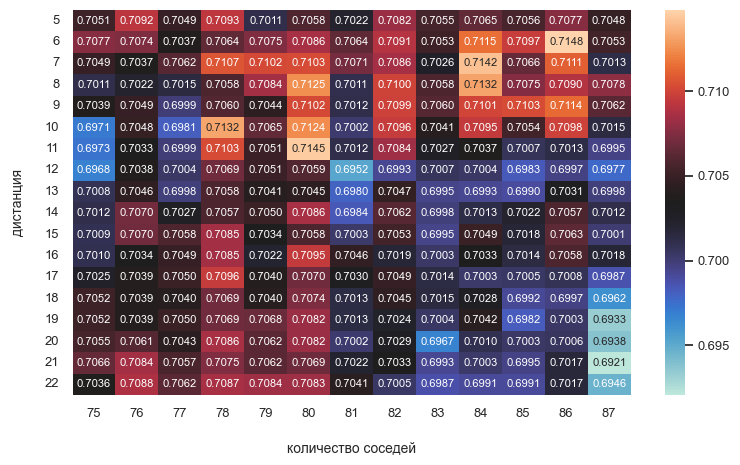

In [2301]:
sns.set_theme(font_scale = 0.85)
sns.set_style('white')

plt.subplots(figsize = (9, 5))

sns.heatmap(grid_2d_knn, cmap = 'icefire', linewidths = 0,
            annot = True, fmt = '.4f', annot_kws = {'fontsize': 8, 'rotation': 'horizontal'})

plt.yticks(rotation = 0)
plt.xlabel("количество соседей", labelpad = 15, fontsize = 10)
plt.ylabel("дистанция", labelpad = 15, fontsize = 10);

По температурной карте самой теплой точкой является дистанция = 6, количество соседей = 86. Данную модель будем считать наилучшей. Ей соответствует среднее значение precision по кроссвалидационным выборкам 0.715. Можно заметить, что разброс данного показателя по карте невысок, precision всех рассмотренных моделей находится в пределах 0.692 - 0.715. Обучим выбранную модель на всем тренировочном наборе. 

In [2308]:
pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors = 86, p = 6, weights = 'uniform'))

pipe_knn.fit(X_train, y_train)

print(classification_report(y_test, pipe_knn.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.790     0.851     0.819       221
           1      0.692     0.597     0.641       124

    accuracy                          0.759       345
   macro avg      0.741     0.724     0.730       345
weighted avg      0.755     0.759     0.755       345



#### 3.3 Итоговая модель

Попробуем обучить ту же модель на тренировочном наборе, из которого удалены признаки, ранее определенные как "лишние" оптимальной моделью логистической регрессии. В данном случае все проверочные метрики стали немного выше, чем было ранее. Оставим эту модель в качестве итоговой и будем использовать "урезанное" количество признаков при дальнейшем анализе.

In [2311]:
pipe_knn = make_pipeline(StandardScaler(),
                           KNeighborsClassifier(n_neighbors = 86, p = 6, weights = 'uniform'))

pipe_knn.fit(X_train[:, weighted_index], y_train)

print(classification_report(y_test, pipe_knn.predict(X_test[:, weighted_index]), digits = 3))

              precision    recall  f1-score   support

           0      0.791     0.855     0.822       221
           1      0.698     0.597     0.643       124

    accuracy                          0.762       345
   macro avg      0.744     0.726     0.733       345
weighted avg      0.757     0.762     0.758       345



#### 4 Сравнение конкурирующих моделей

Оставим в тренировочном и проверочном наборах только те признаки, которые не были определены как "лишние" ранее подобранной моделью логистической регрессии. Их индексы указаны ниже.

In [2163]:
print(f"{weighted_index}".replace("[ ", "").replace("]", "").replace("  ", " ").replace(" ", ", "))

1, 3, 4, 6, 7, 8, 10


In [2312]:
mask = [1, 3, 4, 6, 7, 8, 10]

X_train_drop = X_train[:, mask]
X_test_drop = X_test[:, mask]

In [2313]:
pipes = ["NB", "LR", "KNN"]

pipe_NB = make_pipeline(StandardScaler(), GaussianNB())

pipe_LR = make_pipeline(MinMaxScaler(), 
                        LogisticRegression(penalty = 'l2', solver = 'saga', C = 0.02415,
                                           max_iter = 10000))

pipe_KNN = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 86, p = 6, weights = 'uniform'))

for i in pipes:
    
    eval(f"pipe_{i}").fit(X_train_drop, y_train)
    exec(f"y_predict_{i} = pipe_{i}.predict(X_test_drop)")

#### 4.1 Матрицы ошибок 

In [2314]:
for i in pipes: exec(f"matrix_{i} = confusion_matrix(y_test, y_predict_{i})")

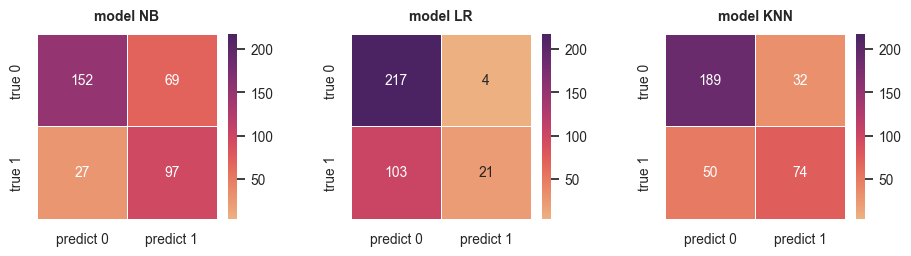

In [2315]:
sns.set_theme(font_scale = 0.9)
sns.set_style('white')

matrices, ax = plt.subplots(1, len(pipes), figsize = (11, 2.4))
plt.subplots_adjust(wspace = 0.4)

vmax = np.max([eval(f"matrix_{i}") for i in pipes])
vmin = np.min([eval(f"matrix_{i}") for i in pipes])

for i in range(1, len(pipes) + 1):
    
    plt.subplot(1, 3, i)
    sns.heatmap(eval(f"matrix_{pipes[i-1]}"), vmax = vmax, vmin = vmin, cmap = 'flare', linewidths = .6,
                annot = True, fmt = 'g', annot_kws = {'fontsize': 10})
    
    plt.title(f"model {pipes[i-1]}", pad = 10, fontsize = 10, fontweight = 'bold')
    plt.xticks(ticks = [0.5, 1.5], labels = ["predict 0", "predict 1"])
    plt.yticks(ticks = [0.5, 1.5], labels = ["true 0", "true 1"])

На данном этапе лучшей моделью по метрике precision является модель LR. Из 25 вин, названных качественными, 21 действительно является качественным. Худшей по той же метрике является модель NB. При этом у всех трех моделей примерно одинаковое значение accuracy. 

#### 4.2 Тестовые метрики

In [2316]:
for i in pipes:
    
    print(f"model {i}\n{classification_report(y_test, eval(f'y_predict_{i}'), digits = 3)}")
    print(f"{' '*5}roc auc{' '*6}{round(roc_auc_score(y_test, eval(f'pipe_{i}').predict_proba(X_test_drop)[:,1]), 3)}\n")

model NB
              precision    recall  f1-score   support

           0      0.849     0.688     0.760       221
           1      0.584     0.782     0.669       124

    accuracy                          0.722       345
   macro avg      0.717     0.735     0.714       345
weighted avg      0.754     0.722     0.727       345

     roc auc      0.797

model LR
              precision    recall  f1-score   support

           0      0.678     0.982     0.802       221
           1      0.840     0.169     0.282       124

    accuracy                          0.690       345
   macro avg      0.759     0.576     0.542       345
weighted avg      0.736     0.690     0.615       345

     roc auc      0.803

model KNN
              precision    recall  f1-score   support

           0      0.791     0.855     0.822       221
           1      0.698     0.597     0.643       124

    accuracy                          0.762       345
   macro avg      0.744     0.726     0.733       

In [2320]:
#функция для графиков кривых ROC, DET, PR

def curves(pipes, X_test = X_test, names = range(1, len(pipes) + 1), positive = 1, color = None):
    
    sns.set_theme(font_scale = 0.9)
    sns.set_style('whitegrid')

    fg = plt.figure(figsize = (10, 10))
    gs = fg.add_gridspec(2, 2)
    ax_roc = fg.add_subplot(gs[0, :])
    ax_det = fg.add_subplot(gs[1, 0])
    ax_pr = fg.add_subplot(gs[1, 1])

    fg.subplots_adjust(wspace = 0.35, hspace = 0.65)
    ax_roc.set_aspect(7/12)

    if (color == None): color = ['orangered', 'royalblue', 'tan', 'darkorange', 'forestgreen', 'hotpink', 'navy', 'grey']

    for i in range(len(pipes)):
        RocCurveDisplay.from_estimator(
            pipes[i], X_test, y_test, pos_label = positive, ax = ax_roc, name = f"model {names[i]}", color = color[i])
        DetCurveDisplay.from_estimator(
            pipes[i], X_test, y_test, pos_label = positive, ax = ax_det, name = f"model {names[i]}", color = color[i])
        PrecisionRecallDisplay.from_estimator(
            pipes[i], X_test, y_test, pos_label = positive, ax = ax_pr, name = f"model {names[i]}", color = color[i])

    ax_roc.set_title("кривая ROC", pad = 15, fontsize = 11, fontweight = 'bold')
    ax_roc.set_xlabel("false positive rate", labelpad = 15)
    ax_roc.set_ylabel("true positive rate", labelpad = 15)

    ax_det.set_title("кривая DET", pad = 15, fontsize = 11, fontweight = 'bold')
    ax_det.set_xlabel("false positive rate", labelpad = 15)
    ax_det.set_ylabel("false negative rate", labelpad = 15)

    ax_pr.set_title("кривая PR", pad = 15, fontsize = 11, fontweight = 'bold')
    ax_pr.set_xlabel("recall", labelpad = 15)
    ax_pr.set_ylabel("precision", labelpad = 15)    

    plt.figtext(0.06, 0.91, f"* positive class: {positive}")

    ax_roc.legend(ncols = 3, loc = 9, bbox_to_anchor = (0, 0, 1, 0.51), bbox_transform = fg.transFigure, framealpha = 0)
    ax_det.get_legend().remove()
    ax_pr.get_legend().remove()

    sns.despine(left = True, bottom = True)

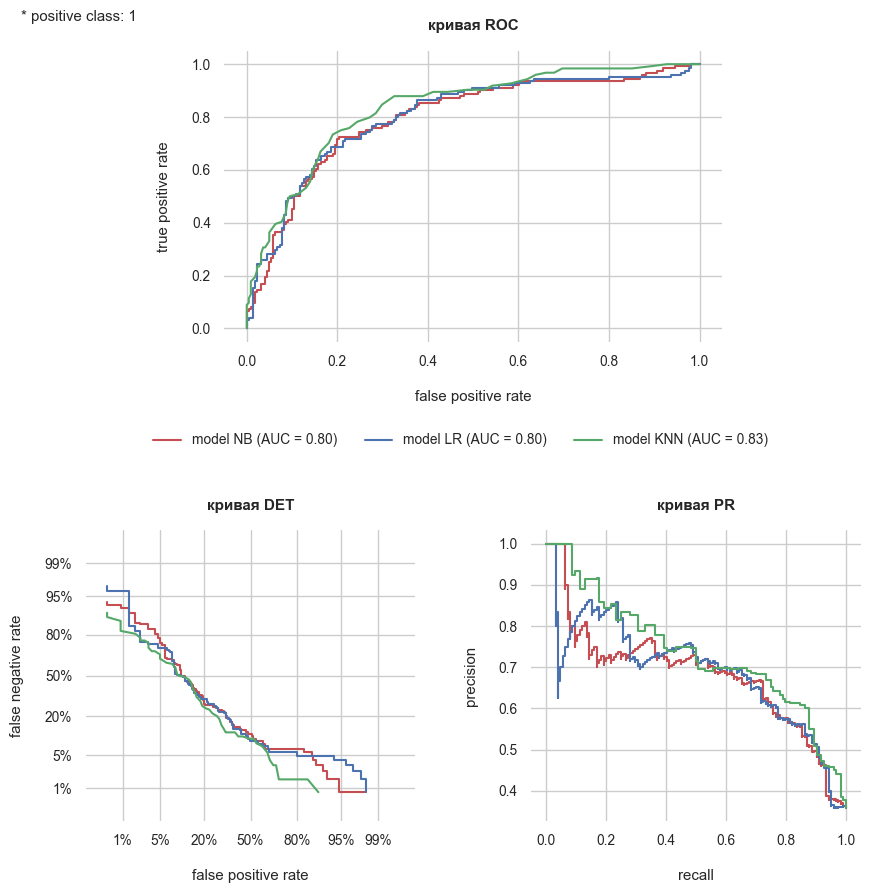

In [2322]:
curves([pipe_NB, pipe_LR, pipe_KNN], X_test_drop, pipes, color = ['r', 'b', 'g'])

Судя по графикам кривых, лучшей моделью является модель KNN. Она обладает самой большой площадью под кривой ROC и самой маленькой площадью под кривой DET. Кривая PR для этой модели практически везде лежит выше, чем кривые других моделей. Данный факт говорит о том, что метрика precision модели KNN ниже, чем у модели LR, не из-за того, что она в целом хуже, а просто выбран неудачный порог принятия решения. Подбор оптимального порога позволит перераспределить false positive и false negative в матрице ошибок, тем самым повысив значение recall.

#### 4.3 Поиск оптимального порога принятия решения

In [2193]:
#функция для графиков кривых с поиском порога

def thresholds(pipe, pos_roc, X_test = X_test, name = '', positive = 1, color_curve = 'g', color_point = 'r'):
    
    fpr, tpr, thresholds_roc = roc_curve(y_test, pipe.predict_proba(X_test)[:,1], pos_label = positive)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, pipe.predict_proba(X_test)[:,1], pos_label = positive)

    pos_pr = np.where(thresholds_pr >= thresholds_roc[pos_roc])[0][0] #позиция для PR

    pos_roc_05 = np.abs(thresholds_roc - 0.5).argmin() #позиция порога 0.5
    pos_pr_05 = np.abs(thresholds_pr - 0.5).argmin()

    sns.set_theme(font_scale = 0.9)
    sns.set_style('dark', {'axes.facecolor': '.91'})

    fg, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize = (11, 5),
                                       subplot_kw = dict(xlim = (-0.02, 1.02), ylim = (-0.02, 1.02), aspect = 1))

    fg.subplots_adjust(wspace = 0.3)

    RocCurveDisplay.from_estimator(
        pipe, X_test, y_test, pos_label = positive, ax = ax_roc, name = f"model {name}", color = color_curve)
    PrecisionRecallDisplay.from_estimator(
        pipe, X_test, y_test, pos_label = positive, ax = ax_pr , name = f"model {name}", color = color_curve)

    ax_roc.plot(fpr[pos_roc_05], tpr[pos_roc_05], 'o', ms = 10, mfc = 'none', mec = color_point)
    ax_roc.plot(fpr[pos_roc], tpr[pos_roc], 'o', ms = 10, mfc = color_point, mec = 'none', alpha = 0.6)

    ax_pr.plot(recall[pos_pr_05], precision[pos_pr_05], 'o', ms = 10, mfc = 'none', mec = color_point)
    ax_pr.plot(recall[pos_pr], precision[pos_pr], 'o', ms = 10, mfc = color_point, mec = 'none', alpha = 0.6)
    
    for i in [0.25, 0.5, 0.75, 1]:
        ax_roc.add_patch(plt.Circle((0, 1), i, fill = False, lw = 1, color = 'w'))
        ax_pr.add_patch(plt.Circle((1, 1), i, fill = False, lw = 1, color = 'w'))

    ax_roc.plot((0, 1), (0, 1), ls = '--', lw = 1, color = 'r')

    ax_roc.set_title("кривая ROC", pad = 35, fontsize = 11, fontweight = 'bold')
    ax_roc.set_xlabel("false positive rate", labelpad = 15)
    ax_roc.set_ylabel("true positive rate", labelpad = 15)

    ax_pr.set_title("кривая PR", pad = 35, fontsize = 11, fontweight = 'bold')
    ax_pr.set_xlabel("recall", labelpad = 15)
    ax_pr.set_ylabel("precision", labelpad = 15)  

    ax_roc.legend(loc = 'upper center', bbox_to_anchor = (0, 0, 1, 1.1), framealpha = 0)
    ax_pr.legend(loc = 'upper center', bbox_to_anchor = (0, 0, 1, 1.1), framealpha = 0)
    
    ax_roc.annotate(f"({pos_roc_05},  0.5)", (fpr[pos_roc_05] + 0.05, tpr[pos_roc_05] - 0.013), fontsize = 9)
    ax_roc.annotate(f"({pos_roc},  {thresholds_roc[pos_roc]:.3f})", (fpr[pos_roc] + 0.05, tpr[pos_roc] - 0.013), fontsize = 9)
    
    text1 = f"в позиции {pos_roc}:   fpr = {fpr[pos_roc]:.3f},  tpr = {tpr[pos_roc]:.3f},  "
    text2 = f"recall = {recall[pos_pr]:.3f},  precision = {precision[pos_pr]:.3f}"
    
    plt.figtext(0.06, -0.08, text1 + text2)
    plt.figtext(0.06, 1, f"* positive class: {positive}")

In [2343]:
#функция для сравнения матриц ошибок при установке порога

def confusion_matrix_thresholds(pipe, threshold, X_test = X_test, name = ''):
    
    y1 = pipe.predict(X_test)
    y2 = np.where(pipe.predict_proba(X_test)[:,1] >= threshold, 1, 0)

    matrix1 = confusion_matrix(y_test, y1)
    matrix2 = confusion_matrix(y_test, y2)

    sns.set_theme(font_scale = 0.9)
    sns.set_style('white')

    plt.subplots(1, 2, figsize = (8, 2.4), subplot_kw = dict(aspect = 1))
    plt.subplots_adjust(wspace = 0)
    
    tmax = np.max([matrix1, matrix2])
    tmin = np.min([matrix1, matrix2])
    
    pipes = ['', ' thresholds']

    for i in [1, 2]:

        plt.subplot(1, 2, i)
        sns.heatmap(eval(f"matrix{i}"), vmax = tmax, vmin = tmin, cmap = 'flare', linewidths = .6,
                    annot = True, fmt = 'g', annot_kws = {'fontsize': 10})

        plt.title(f"model {name}{pipes[i-1]}", pad = 10, fontsize = 10, fontweight = 'bold')
        plt.xticks(ticks = [0.5, 1.5], labels = ["predict 0", "predict 1"])
        plt.yticks(ticks = [0.5, 1.5], labels = ["true 0", "true 1"])

In [2363]:
#функция для сравнения метрик при установке порога

def report_thresholds(pipe, threshold, X_test = X_test, name = ''):
    
    y_thresholds = np.where(pipe.predict_proba(X_test)[:,1] >= threshold, 1, 0)
    
    print(f"model {name}\n{classification_report(y_test, pipe.predict(X_test), digits = 3)}")
    print(f"{' '*5}roc auc{' '*6}{round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]), 3)}\n\n")

    print(f"model {name} thresholds\n{classification_report(y_test, y_thresholds, digits = 3)}")
    print(f"{' '*5}roc auc{' '*6}{round(roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]), 3)}")

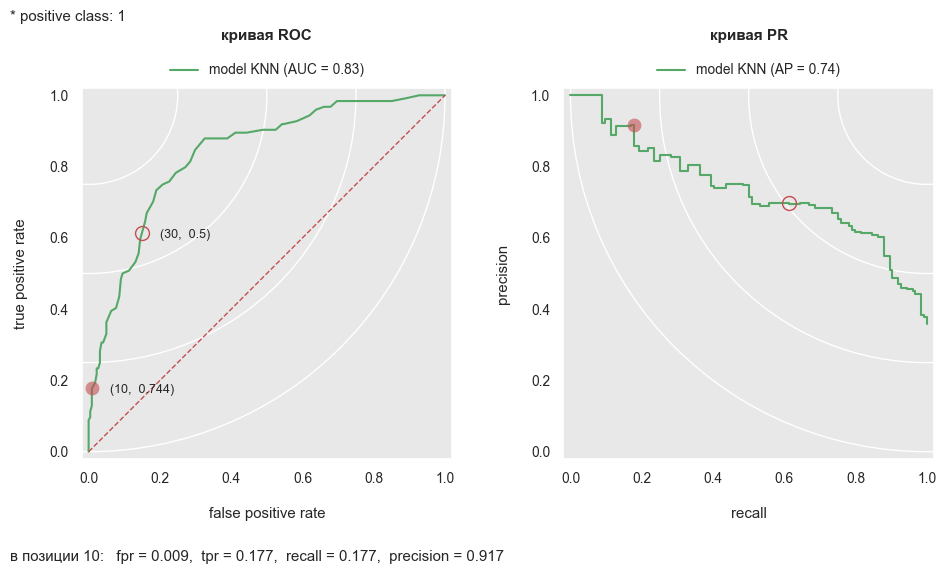

In [2328]:
thresholds(pipe_KNN, 10, X_test_drop, 'KNN')

Для модели KNN позиция 10 на кривой ROC соответствует порогу принятия решения 0.744 и значению precision 0.92 на кривой PR. Будем считать эту позицию оптимальной, так как слишком сильное завышение порога может привести к тому, что на тренировочном наборе значение precision = 1, а на тестовом судьба сложится так, что модель сочтет все вина недостаточно "хорошими", чтобы называться качественными. Тогда тестовый precision будет 0 и оценка за работу тоже.

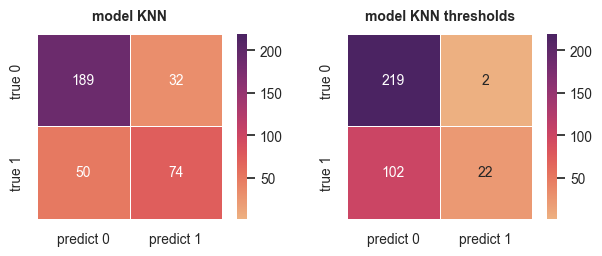

In [2354]:
confusion_matrix_thresholds(pipe_KNN, 0.744, X_test_drop, 'KNN')

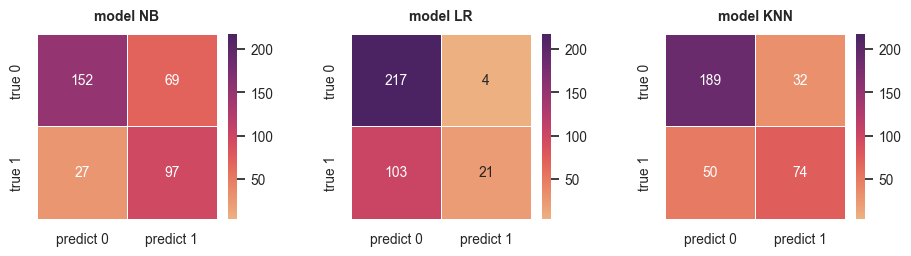

In [2355]:
matrices

Глядя на матрицу ошибок модели KNN с порогом принятия решения 0.744, можно сделать вывод, что установка такого порога значительно улучшила ситуацию. Модель предсказала 24 вина как качественные и 22 из них действительно оказались качественными. Ее precision = 0.92 против precision = 0.84 у модели LR. Итак, модель KNN с порогом 0.744 признается лучшей, она всех победила и пойдет дальше в область работы 3.

In [2370]:
report_thresholds(pipe_KNN, 0.744, X_test_drop, 'KNN')

model KNN
              precision    recall  f1-score   support

           0      0.791     0.855     0.822       221
           1      0.698     0.597     0.643       124

    accuracy                          0.762       345
   macro avg      0.744     0.726     0.733       345
weighted avg      0.757     0.762     0.758       345

     roc auc      0.834


model KNN thresholds
              precision    recall  f1-score   support

           0      0.682     0.991     0.808       221
           1      0.917     0.177     0.297       124

    accuracy                          0.699       345
   macro avg      0.799     0.584     0.553       345
weighted avg      0.766     0.699     0.625       345

     roc auc      0.834


#### 4.4 Лучшая модель

In [ ]:
mask = [1, 3, 4, 6, 7, 8, 10]

X_train_drop = X_train[:, mask]
X_test_drop = X_test[:, mask]

In [2379]:
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 86, p = 6, weights = 'uniform'))
pipe.fit(X_train_drop, y_train)

y_predict = np.where(pipe.predict_proba(X_test_drop)[:,1] >= 0.744, 1, 0)

print(precision_score(y_test, y_predict).round(3))

0.917
